In [35]:
import warnings

warnings.filterwarnings('ignore')

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
# Download the latest S&P 500 constituents
sp_df = pd.read_html('https://wikipedia.org/wiki/List_of_S%26P_500_companies', flavor='html5lib')[0]
sp_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*****

<Axes: title={'center': 'S&P500, 1yr High/Low count: absolute & relative series'}, xlabel='Date'>

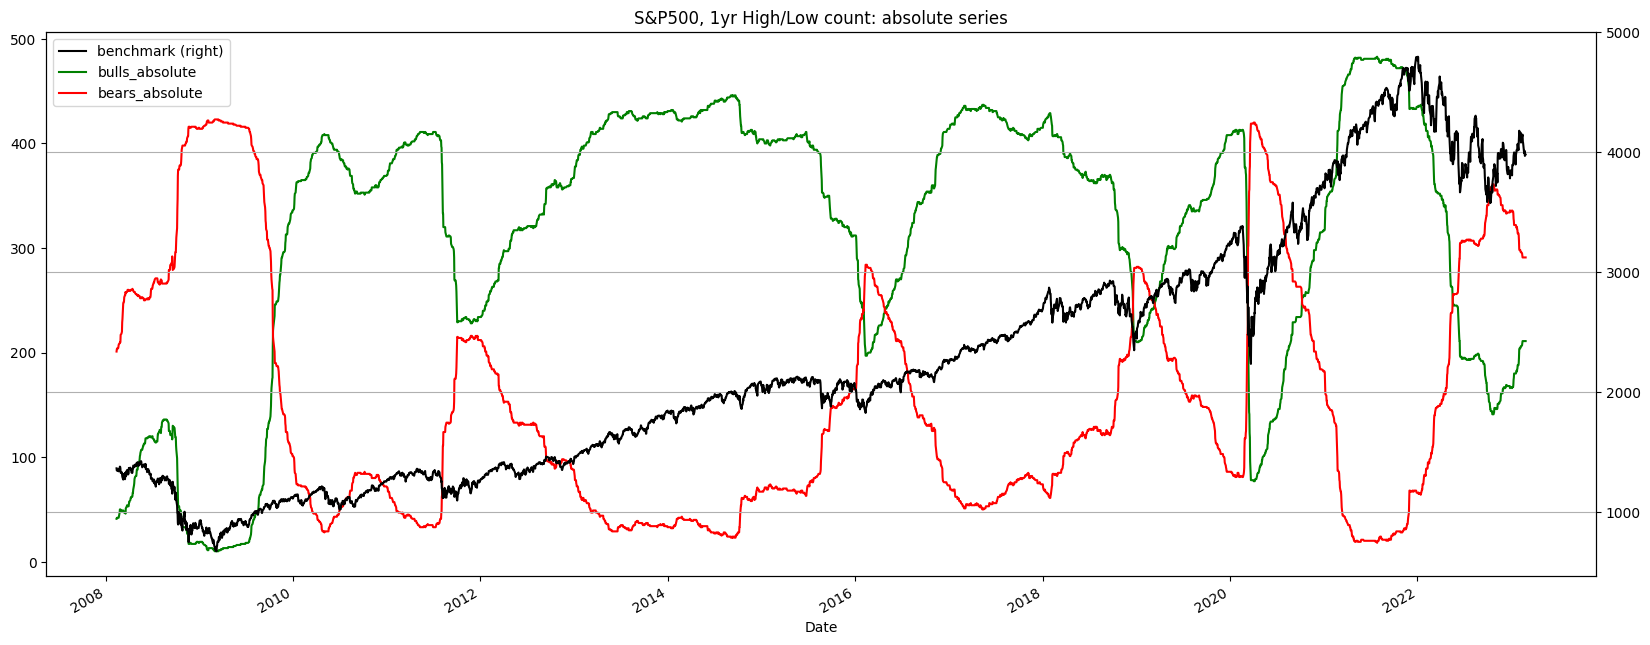

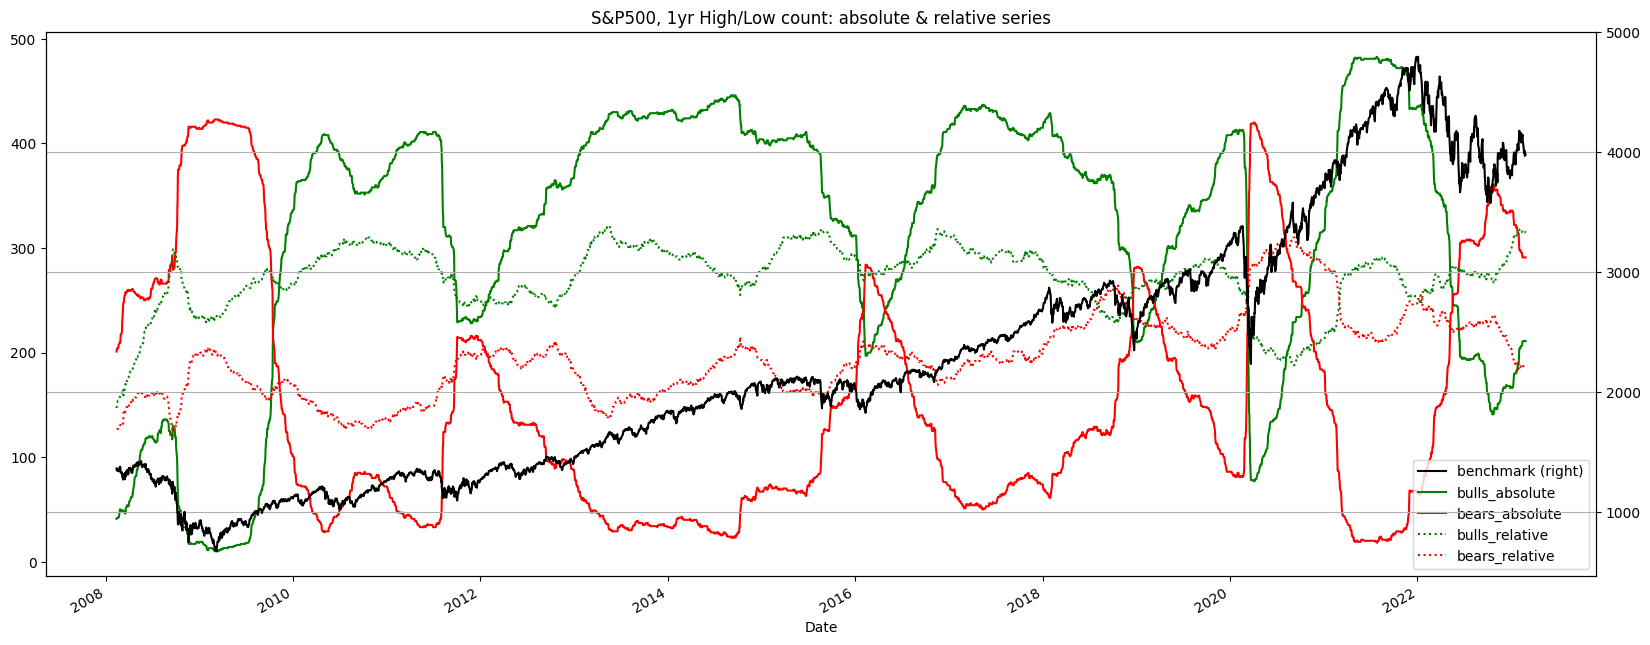

In [29]:
# Reformat to ensure compatibility with Yahoo Finance
sp_df['Symbol'] = sp_df['Symbol'].str.replace('.', '-')

bm_ticker = '^GSPC'
tickers_list = [bm_ticker] + list(sp_df['Symbol'])[:]

# Variables instantiation
window = 252
show_batch = True
df_abs = pd.DataFrame()
batch_size = 20
loop_size = int(len(tickers_list) // batch_size) + 2

# Batch download
for t in range(1, loop_size):
    m = (t - 1) * batch_size
    n = t * batch_size
    batch_list = tickers_list[m:n]

    batch_download = \
        yf.download(tickers=batch_list,
                    start='2007-01-01',
                    end=None,
                    interval='1d',
                    group_by='column',
                    auto_adjust=True,
                    prepost=True,
                    proxy=False)['Close']

    df_abs = df_abs.join(batch_download, how='outer')

# Aggregate results
bullbear = pd.DataFrame()
bullbear['benchmark'] = round(df_abs[bm_ticker].copy(), 2)

df_rel = round(df_abs.divide(df_abs[bm_ticker], axis=0).mul(df_abs[bm_ticker][0]), 1)
df_rel = pd.DataFrame(data=np.where(df_rel >= df_rel.rolling(window).max(), 1,
                                    np.where(df_rel <= df_rel.rolling(window).min(), -1, np.nan)),
                      index=df_rel.index,
                      columns=df_rel.columns).fillna(method='ffill')

df_abs = pd.DataFrame(data=np.where(df_abs >= df_abs.rolling(window).max(), 1,
                                    np.where(df_abs <= df_abs.rolling(window).min(), -1, np.nan)),
                      index=df_abs.index,
                      columns=df_abs.columns).fillna(method='ffill')

bullbear['bulls_absolute'] = df_abs[df_abs > 0].count(axis=1)
bullbear['bears_absolute'] = df_abs[df_abs < 0].count(axis=1)
bullbear['bulls_relative'] = df_rel[df_rel > 0].count(axis=1)
bullbear['bears_relative'] = df_rel[df_rel < 0].count(axis=1)

bullbear[280:][['benchmark', 'bulls_absolute', 'bears_absolute',
                ]].plot(figsize=(20, 8),
                        style=['k', 'g', 'r'],
                        grid=True,
                        secondary_y=['benchmark'],
                        title='S&P500, 1yr High/Low count: absolute series')

bullbear[280:][['benchmark', 'bulls_absolute', 'bears_absolute', 'bulls_relative', 'bears_relative']].plot(
    figsize=(20, 8),
    style=['k', 'g', 'r', 'g:', 'r:'],
    grid=True,
    secondary_y=['benchmark'],
    title='S&P500, 1yr High/Low count: absolute & relative series')

# Relative function

In [30]:
def relative(df, _o, _h, _l, _c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end, rebase=True):
    '''
    df: df
    bm_df, bm_col: df benchmark dataframe & column name
    ccy_df, ccy_col: currency dataframe & column name
    dgt: rounding decimal
    start/end: string or offset
    rebase: boolean rebase to beginning or continuous series
    '''
    # Slice df dataframe from start to end period: either offset or datetime
    df = df[start:end]

    # Inner join of benchmark & currency: only common values are preserved
    df = df.join(bm_df[[bm_col]], how='inner')
    df = df.join(ccy_df[[ccy_col]], how='inner')

    # Rename benchmark name as bm and currency as ccy
    df.rename(columns={bm_col: 'bm', ccy_col: 'ccy'}, inplace=True)

    # Adjustment factor: calculate the scalar product of benchmark and currency
    df['bmfx'] = round(df['bm'].mul(df['ccy']), dgt).fillna(method='ffill')
    if rebase == True:
        df['bmfx'] = df['bmfx'].div(df['bmfx'][0])

    # Divide absolute price by fxcy adjustment factor and rebase to first value
    df['r' + str(_o)] = round(df[_o].div(df['bmfx']), dgt)
    df['r' + str(_h)] = round(df[_h].div(df['bmfx']), dgt)
    df['r' + str(_l)] = round(df[_l].div(df['bmfx']), dgt)
    df['r' + str(_c)] = round(df[_c].div(df['bmfx']), dgt)
    df = df.drop(['bm', 'ccy', 'bmfx'], axis=1)

    return (df)

# Softbank in Absolute JPY & Relative to Nasdaq in USD

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Softbank Absolute in JPY vs Relative to Nasdaq in USD Rebased'}, xlabel='Date'>

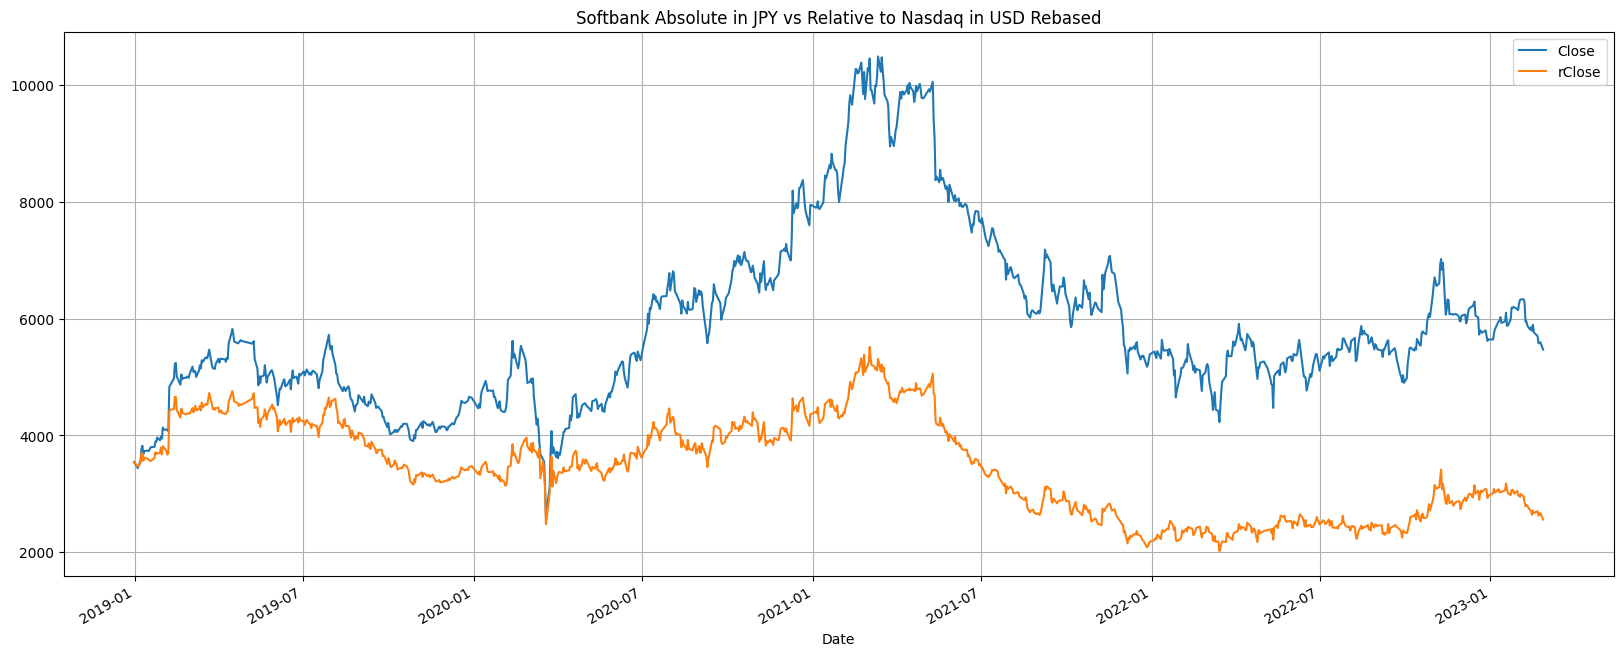

In [34]:
ticker = '9984.T'  # Softbank
ohlc = ['Open', 'High', 'Low', 'Close']
_o, _h, _l, _c = [ohlc[h] for h in range(len(ohlc))]
start = '2018-12-30'
end = None
df = round(
    yf.download(tickers=ticker,
                start=start,
                end=end,
                interval='1d',
                group_by='column',
                auto_adjust=True,
                prepost=True,
                threads=True,
                proxy=None), 2)

bm_df = pd.DataFrame()
bm_ticker = '^IXIC'  # Nasdaq
bm_col = 'nasdaq'
ccy_df = pd.DataFrame()
ccy_ticker = 'USDJPY=X'
ccy_col = 'JPY'
dgt = 5

bm_df[bm_col] = yf.download(tickers=bm_ticker,
                            start=start,
                            end=end,
                            interval='1d',
                            group_by='column',
                            auto_adjust=True,
                            prepost=True,
                            threads=True,
                            proxy=None)['Close']

ccy_df[ccy_col] = yf.download(tickers=ccy_ticker,
                              start=start,
                              end=end,
                              interval='1d',
                              group_by='column',
                              auto_adjust=True,
                              prepost=True,
                              threads=True,
                              proxy=None)['Close']

df = relative(df, _o, _h, _l, _c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end, rebase=True)

df[['Close', 'rClose']].plot(figsize=(20, 8), grid=True,
                             title='Softbank Absolute in JPY vs Relative to Nasdaq in USD Rebased')

# Comparison of 3 Stocks Across 3 Different Sectors

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'GEMS Absolute Prices vs. Relative Series'}, xlabel='Date'>

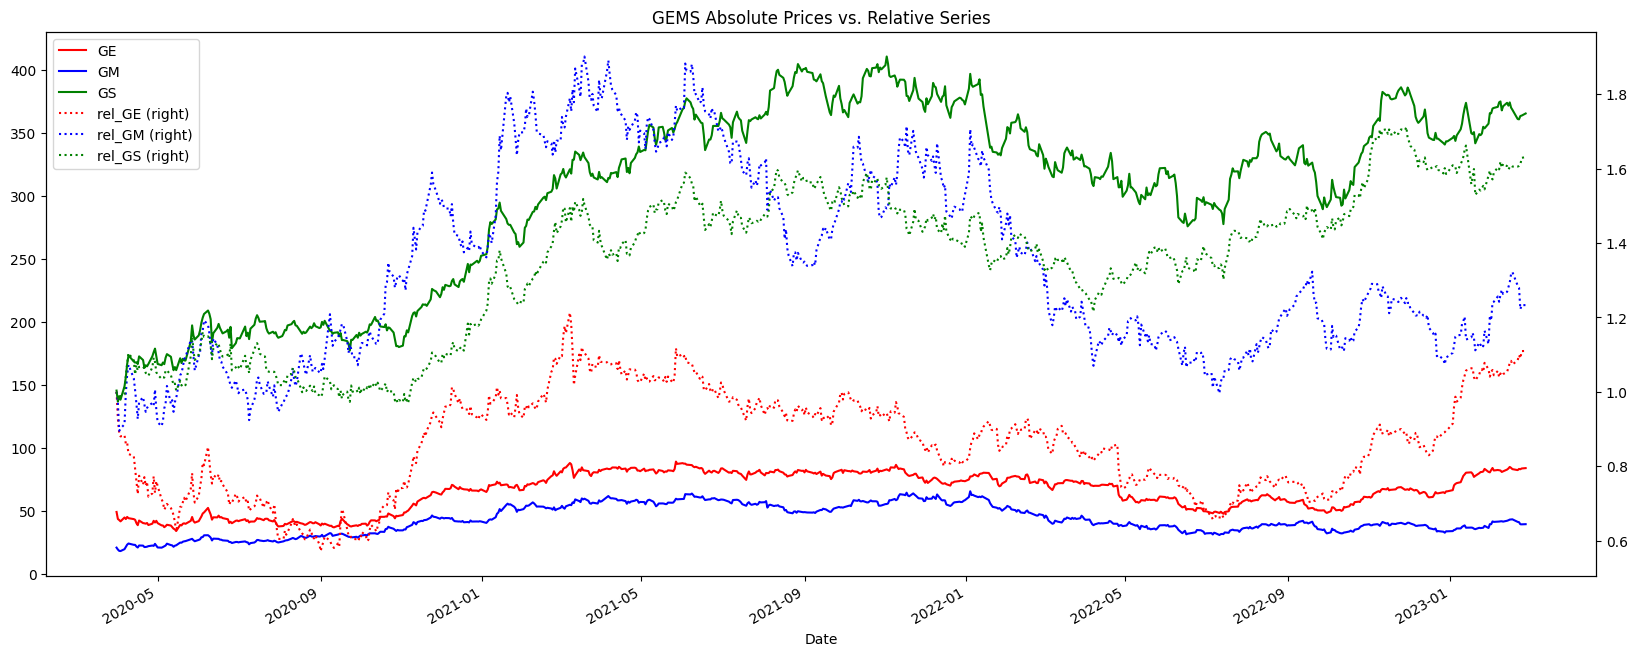

In [38]:
tickers_list = ['GE', 'GM', 'GS']

# Dataframe instantiation
gems = pd.DataFrame()
start = '2020-03-31'
benchmark = yf.download(tickers='^GSPC',
                        start=start,
                        end=None,
                        interval='1d',
                        group_by='column',
                        auto_adjust=True,
                        prepost=True,
                        threads=True,
                        proxy=None)['Close']

failed = []
rel_ticker_list = []
for n, ticker in enumerate(tickers_list):
    # Download and process data
    try:
        gems[ticker] = yf.download(tickers=ticker,
                                   start=start,
                                   end=None,
                                   interval='1d',
                                   group_by='column',
                                   auto_adjust=True,
                                   prepost=True,
                                   threads=True,
                                   proxy=None)['Close']
        gems['rel_' + ticker] = gems[ticker].div(benchmark * gems[ticker][0]) * benchmark[0]
        rel_ticker_list.append('rel_' + ticker)
    except:
        failed.append(ticker)
gems = gems[tickers_list + rel_ticker_list]
gems.plot(figsize=(20, 8),
          secondary_y=rel_ticker_list,
          style=['r', 'b', 'g', 'r:', 'b:', 'g:'],
          title='GEMS Absolute Prices vs. Relative Series')
